In [14]:
from gluonts.dataset.split import split
from gluonts.torch import PatchTSTEstimator
from gluonts.dataset.pandas import PandasDataset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.common import ListDataset
import torch
from gluonts.model.predictor import Predictor

import os
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [3]:
from pathlib import Path
import os

load_dotenv()

True

In [4]:
from data.get_data import get_data_frame, get_max_user_count

In [5]:
df = get_data_frame(1)
df.set_index('timestamp', inplace=True)

Connected to database


In [15]:

freq = "15min"
prediction_length = 96

# Mock dataframe example (replace with your actual data)
# df = pd.DataFrame({"user_count": [...]}, index=pd.date_range(...))

# Create training dataset
train_ds = ListDataset(
    [{"start": df.index[0], "target": df['user_count'].values}],
    freq=freq
)

# Create testing dataset
test_ds = ListDataset(
    [{"start": df.index[0], "target": df['user_count'].values}],
    freq=freq
)

# Set up CSV Logger
logger = CSVLogger(save_dir="./logs/", name="patchtst_training")

# Define checkpointing callback to save the model
model_checkpoint = ModelCheckpoint(
    dirpath="./models/",
    filename="best_model",
    save_top_k=1,
    monitor="val_loss",
    mode="min",
)

# Initialize estimator
estimatorTST = PatchTSTEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length * 10,
    patch_len=16,
    stride=8,
    trainer_kwargs={
        "accelerator": "cpu",
        "max_epochs": 30,
        "logger": logger,
        "callbacks": [model_checkpoint],
        "log_every_n_steps": 1,
    }
)

# Train the model using the train() method
predictorTST = estimatorTST.train(train_ds)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/deep/marius/ml/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/deep/marius/ml/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/deep/marius/ml/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/deep/marius/ml/models exists and is not empty.

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PatchTSTModel | 11.8 M | train
------------------------------------------------
11.8 M    Trainable params
3.8 K     Non-trainable params
11.8 M    Total params
47.318    Total estimated model params size (MB)
34        Module

Training: |                                                                                     | 0/? [00:00<?…

Epoch 0, global step 50: 'train_loss' reached 8.54441 (best 8.54441), saving model to './logs/patchtst_training/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
/home/deep/marius/ml/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
Epoch 1, global step 100: 'train_loss' reached 7.14212 (best 7.14212), saving model to './logs/patchtst_training/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.52412 (best 6.52412), saving model to './logs/patchtst_training/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.33231 (best 6.33231), saving model to './logs/patchtst_training/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: '

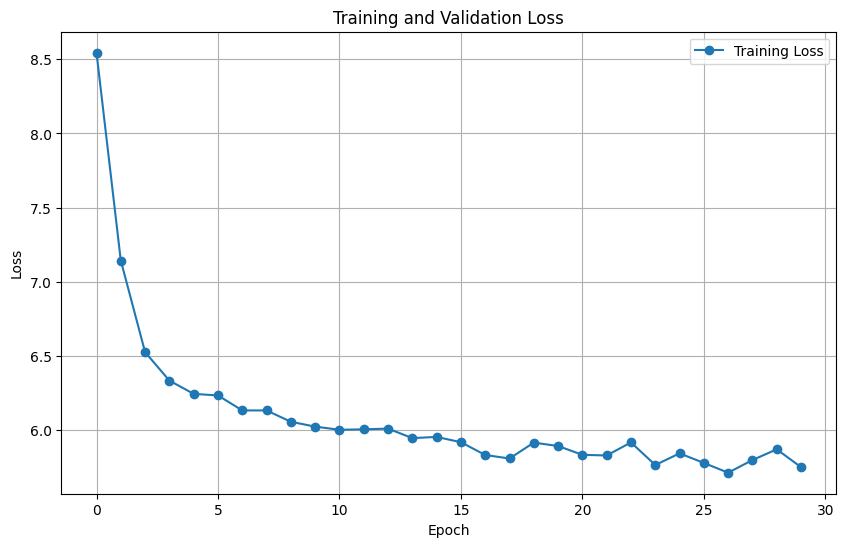

In [16]:
# Read the CSV log and plot training and validation losses
metrics_path = Path(logger.log_dir) / "metrics.csv"
metrics = pd.read_csv(metrics_path)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(metrics["epoch"], metrics["train_loss"], label="Training Loss", marker="o")
if "val_loss" in metrics.columns:
    plt.plot(metrics["epoch"], metrics["val_loss"], label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [17]:
# Save the predictor
model_save_path = Path(f"./models/")
if not model_save_path.exists():
    os.makedirs(model_save_path)

predictorTST.serialize(model_save_path)

# Make forecasts
forecasts = list(predictorTST.predict(test_ds))